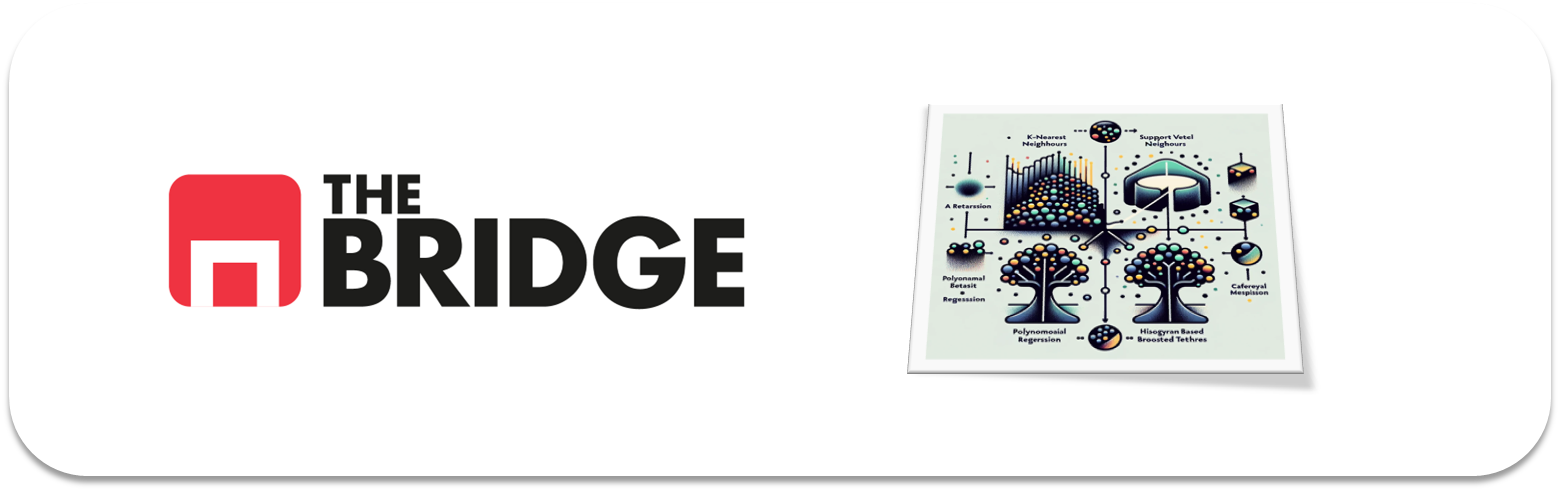

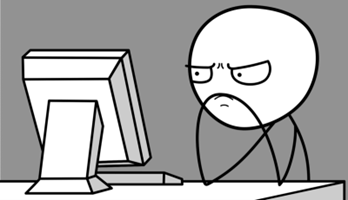

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etpas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita detectar potenciales pacientes pero con un alto nivel de acierto en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de predicción de quién desarrollará o no el cáncer y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

*Tal y como lo han planteado, se trataría de contruir un modelo que permita separar personas que vayan a desarrollar cáncer de mama (si no se hace nada al respecto, claro) y las que no. Por tanto, estamos hablando de **un problema de clasificación binaria**.*

*Además, están especialmente preocupados por que el modelo no diga que alguie va a padecer cáncer (si no se hace nada) y luego no lo padezca porque no quieren incluirlo en ese caso en el programa y tener un paciente que no les serviría de caso de éxtio (como no iba a tener cáncer, el tratamiento tendría "éxito" falso), les costaría dinero y podría causarle daño. Estamos hablando de ser muy precisos en la clase "desarrollar cáncer", es decir, que cuando nuestro modelo diga tener cáncer acierte en un porcentaje muy alto. Y por supuesto, que no lo haga con 1 paciente de los probados, aunque eso no se especifica*  

*En definitiva, queremos que **la precisión de la clase "desarrollar cáncer" sea muy alto**, sin descuidar el recall de la misma, pero sin que sea fundamental.*  

*NOTA (ética): No es que prefiramos dejar fuera posibles pacientes y no tratarlo, es que todavía es un tratamiento experimental que quiere probarse con casos aun no desarrollados. Si fuera un tratamiento "en el mercado" no sería ético dejar a alguien fuera del mismo porque lo diga únicamente un modelo de ML*

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [2]:
df = pd.read_csv("./data/wisconsin_cancer.csv", sep = "|")

In [3]:
df.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374
5,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791
6,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442
7,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654
8,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703
9,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

*Son todo variables numéricas salvo diagnosis (presumiblemente la variable target), de las que podemos hacer un describe para cerciroranos 100%:*

In [5]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600


*Si buscamos en la página web encontraremos que la variable target es `diagnosis`, pero podríamos haberlo deducido también del tipo de variables, verlo en la página es como preguntar a "Negocio", lo correcto realmente*

In [6]:
target = "diagnosis"

NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

### Ejercicio 3: Split

Haz el split en train y test.

In [7]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

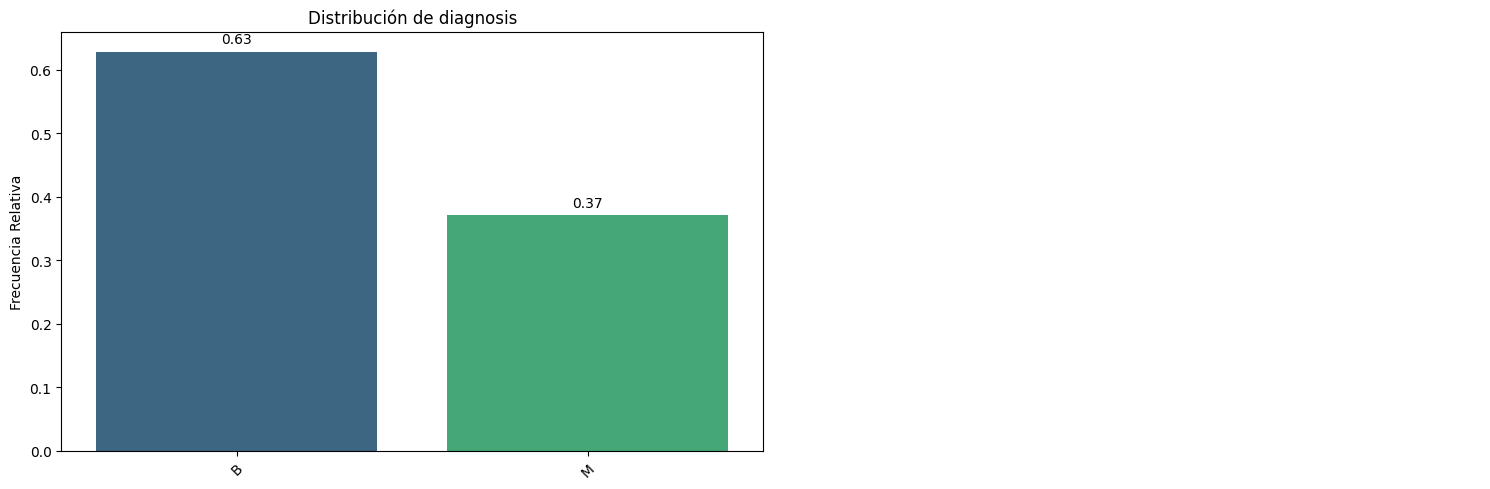

In [8]:
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores= True, relativa= True)

*El dataset esta ligeramente desbalanceado hacia los tumores benignos o casos en los que el desarrollo del cáncer no se dará. Notaremos su impacto al probar por ejemplo el hiperparámetro class_weight o el correspondiente al modelo seleccionado. Nos lo apuntamos porque aquí queremos ser muy precisos con la minoritaria (M)*

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

*Todas las columnas son numéricas así que podríamos hacer un pairplot o emplear nuestras funciones amigas que muestran los histogramas. Dado el volumen de features que hay (25), vamos a usar varios pairplots de 5 en 5 e iremos comentándolos*

In [9]:
features_num = train_set.columns.to_list()
features_num.remove(target) # Aunque luego lo iré añadiendo para ir comparando con el target
print(len(features_num))

25


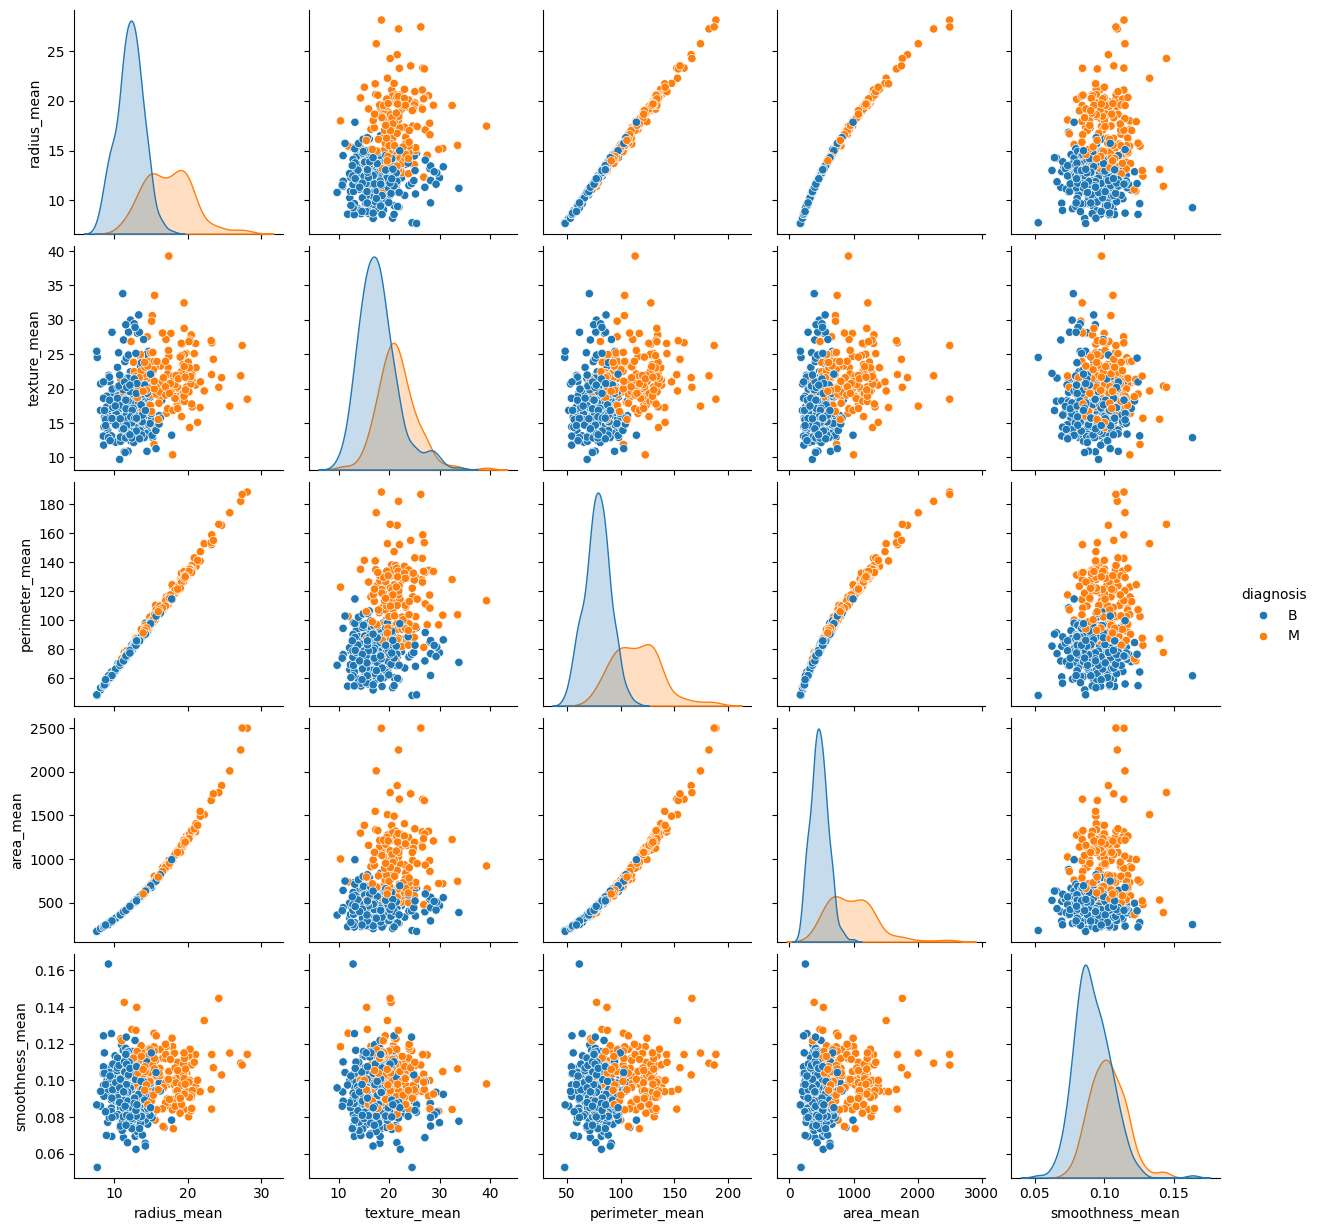

In [10]:
# Metodo 1, varios pairplot de seaborn, con el hue asignado a la variable target. Varios porque son muchas
sns.pairplot(train_set[features_num[0:5] + [target]], hue = target)

*De esta primera "oleada", todas parecen interesantes, aunque "area_mean", "perimeter_mean" y "radius_mean" son las más interesantes, eso sí también están muy correladas entre ellas, lo tendría que tenerlo en cuenta en los modelos en los que haga una regresión internamente o incluso para los modelos basados en árboles para quizás no incorporar las tres sino sólo una de ellas*

In [11]:
to_investigate_1 = ["area_mean","perimeter_mean","radius_mean"] # Ojo me las quedo, solo me las apunto por si tuviera que quitarlas al hacer la validación cruzada y ver que esta es baja...


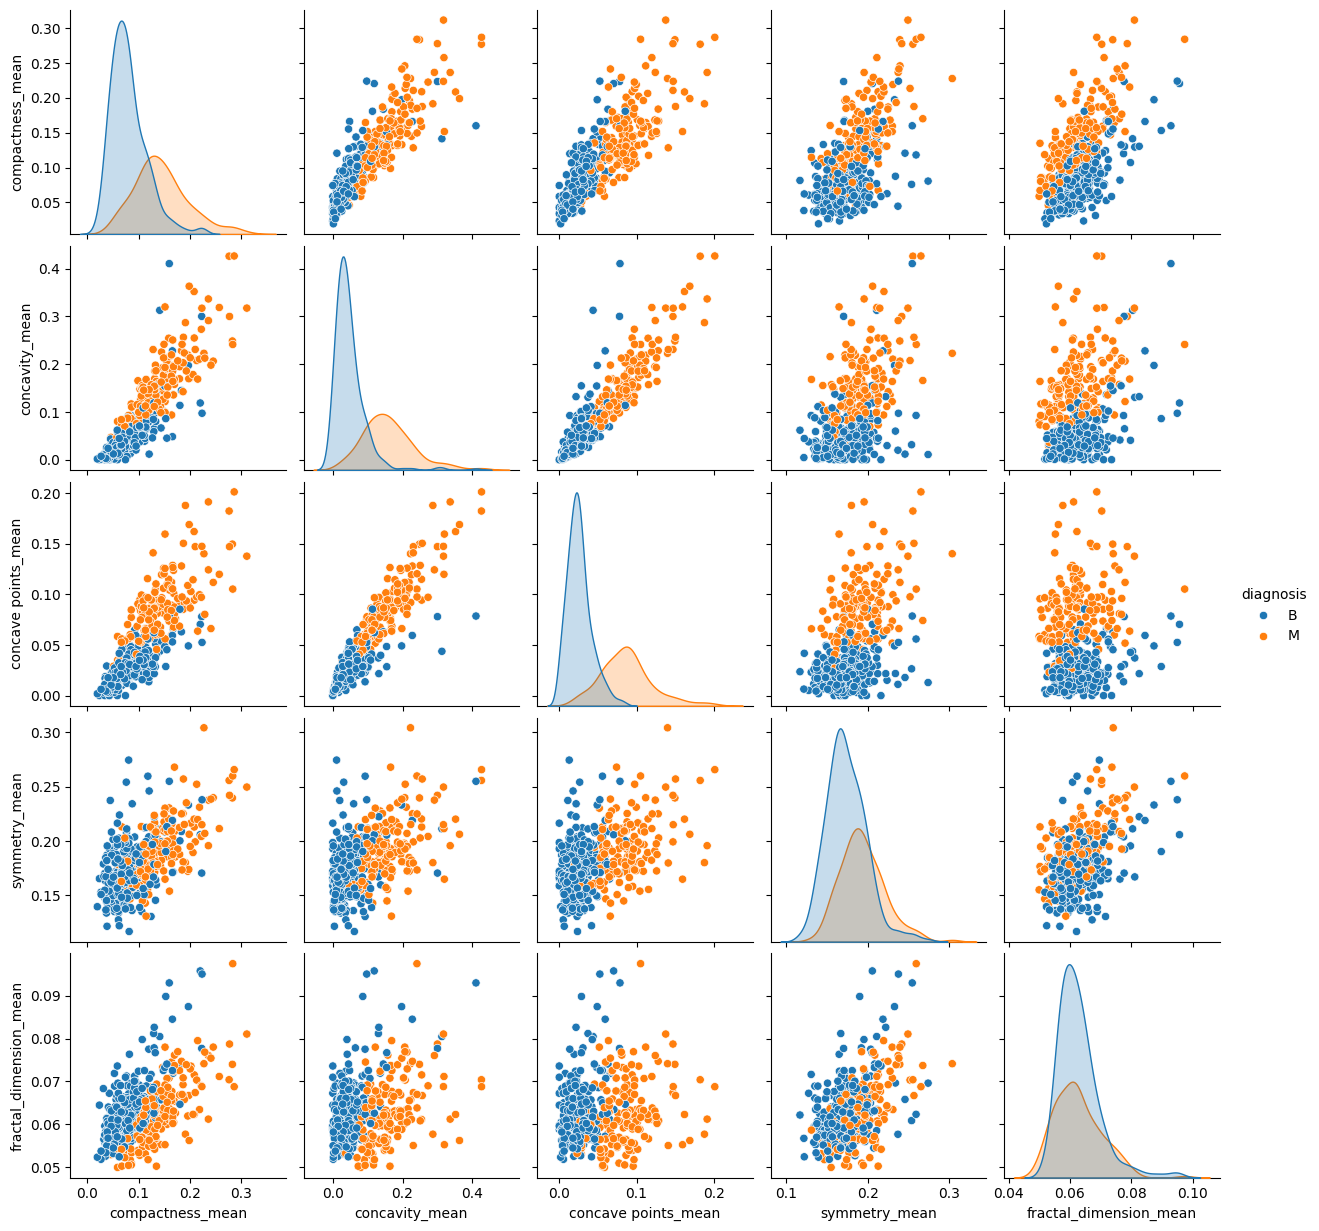

In [12]:
sns.pairplot(train_set[features_num[5:10] + [target]], hue = target)

*De nuevo nos interesan algunas de forma especial "compactness_mean", "concavity_mean" y "concave_points_mean"(fijate en cuanto de separadas están sus distribuciones respecto al target). De nuevo tienen una correlación clara entre ellas (fijate en los scatter entre cada dos de las anteriores)*

In [13]:
to_investigate_2 = ["compactness_mean","concavity_mean", "concave_points_mean"] # Como en el anterior to_investigate, esta es una lista por si tuviera que quitar alguna de ellas debido a la correlación que tienen, lo veremos en el ejercicio de comparación de modelos


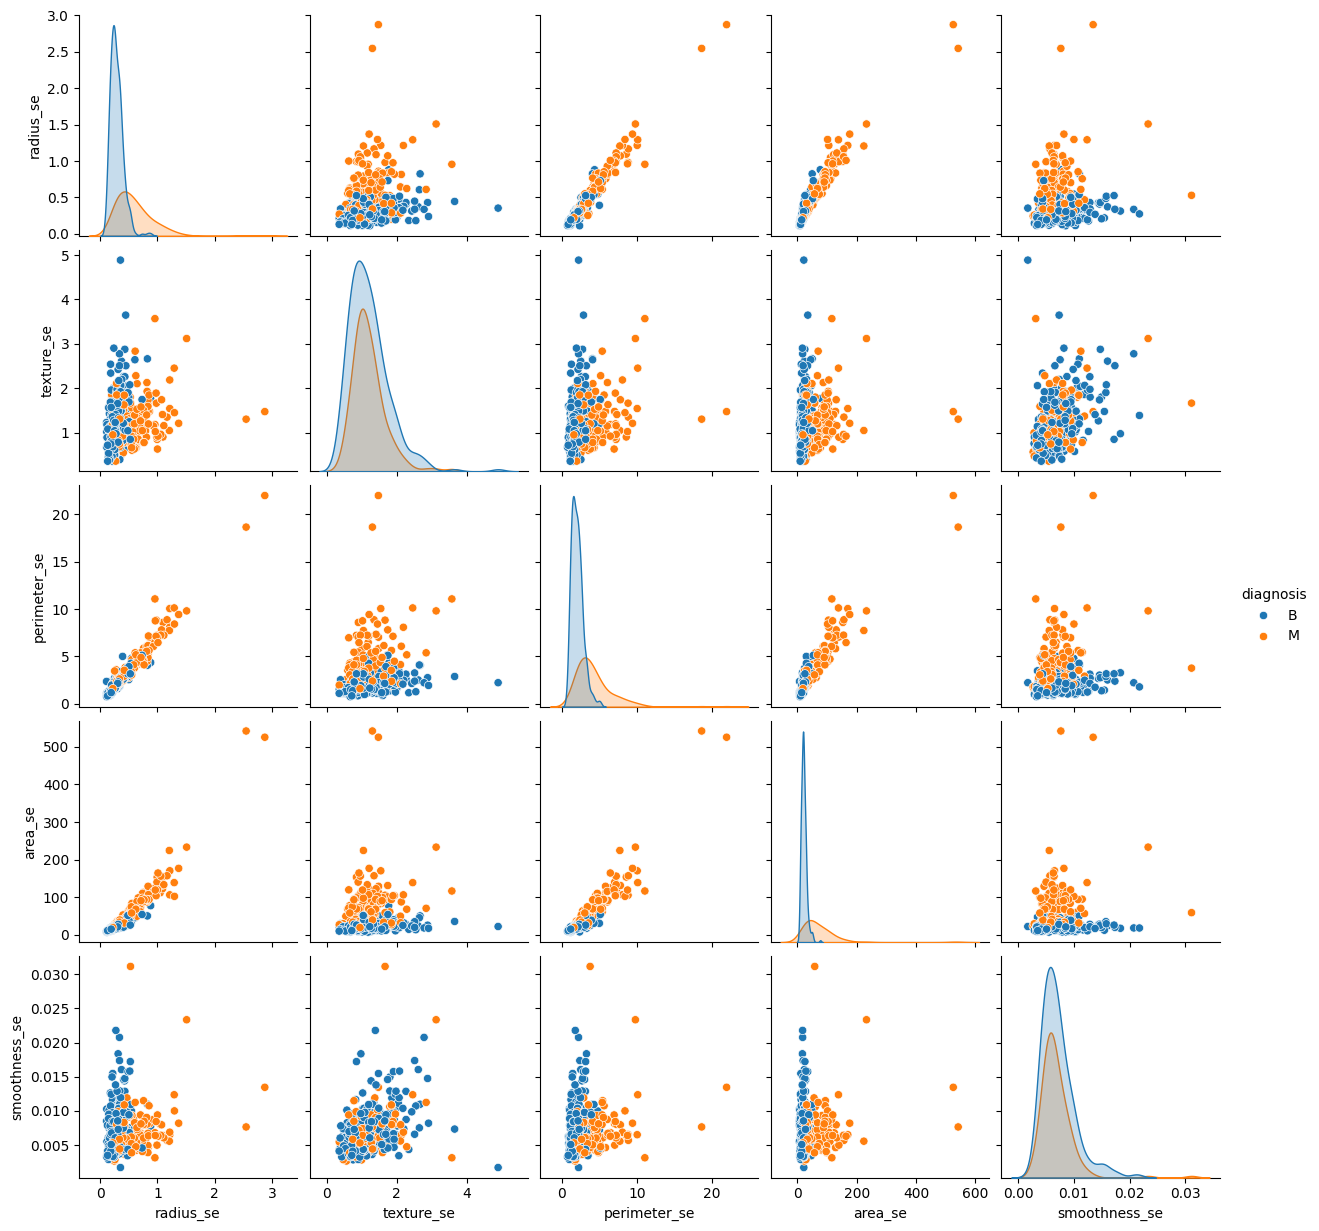

In [14]:
sns.pairplot(train_set[features_num[10:15] + [target]], hue = target)

*En este caso, hay dos potenciales features que no nos dicen mucho "smoothness_se" y "texture_se" (observa que las distribuciones están casi completamente superpuestas) y otras tres "area_se", "perimeter_se" y "radius_se" que tienen capacidad discriminativia (observa las distribuciones respecto al target que tienen partes no solapadas evidentes). Estas están correladas entre sí y probablemente con radius_mean, area_mean, perimeter_mean*

In [15]:
to_investigate_3 = ["area_se","perimeter_se","radius_se"]
features_num_2 = ["smoothnes_se", "texture_se"]
corr = train_set.corr(numeric_only= True)
corr[to_investigate_1].loc[to_investigate_3]

,area_mean,perimeter_mean,radius_mean
area_se,0.788217,0.729937,0.719478
perimeter_se,0.710713,0.676192,0.656071
radius_se,0.722728,0.680739,0.666954


*Como podíamos intuir por los nombres hay una correlación destacada entre ellas también, haremos un juego particular sólo para un tipo de feature de estas. Antes completemos el análisis bivariante contra el target usando el pairplot*

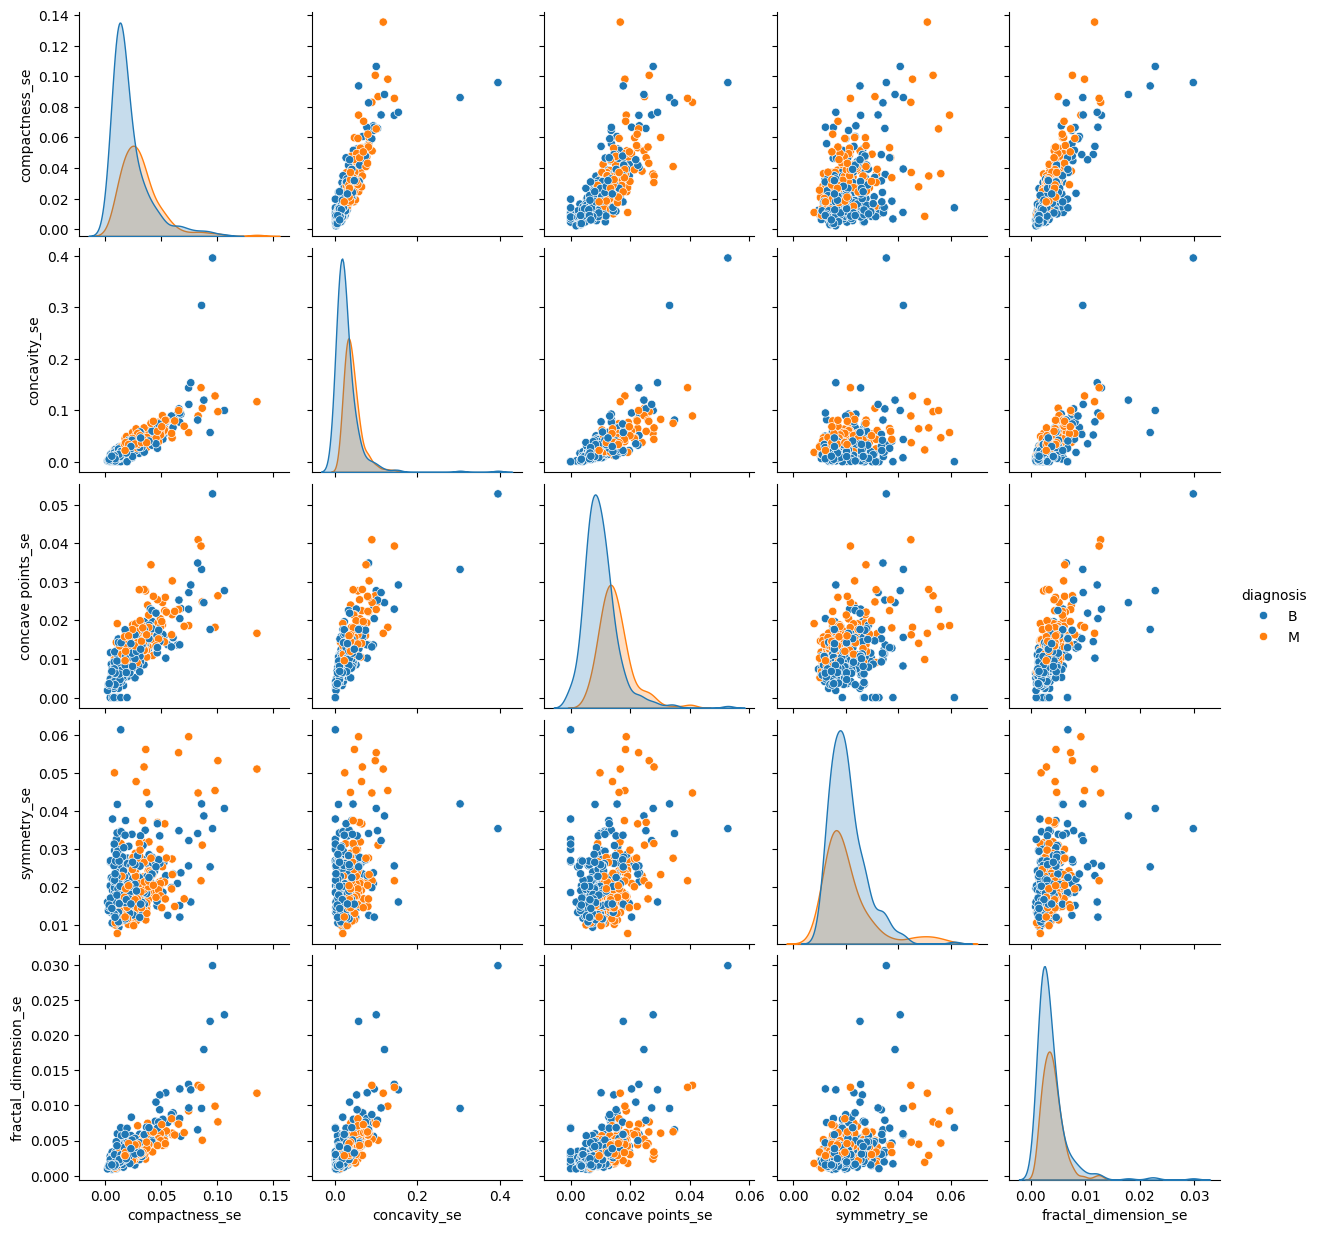

In [16]:
sns.pairplot(train_set[features_num[15:20] + [target]], hue = target)

*Este es el juego de features con menos features aparentemente significativas, aunque, salvo "fractal_dimension_se" en la que las superosición es casi completa, aunque hay un ligero desplazamiento, todas tienen partes no solapadas y desplazamientos. Me quedo con todas ellas, salvo "fractal_dimension_se" que pasa a segundo dataset*

In [17]:
features_num_2.append("fractal_dimension_se")

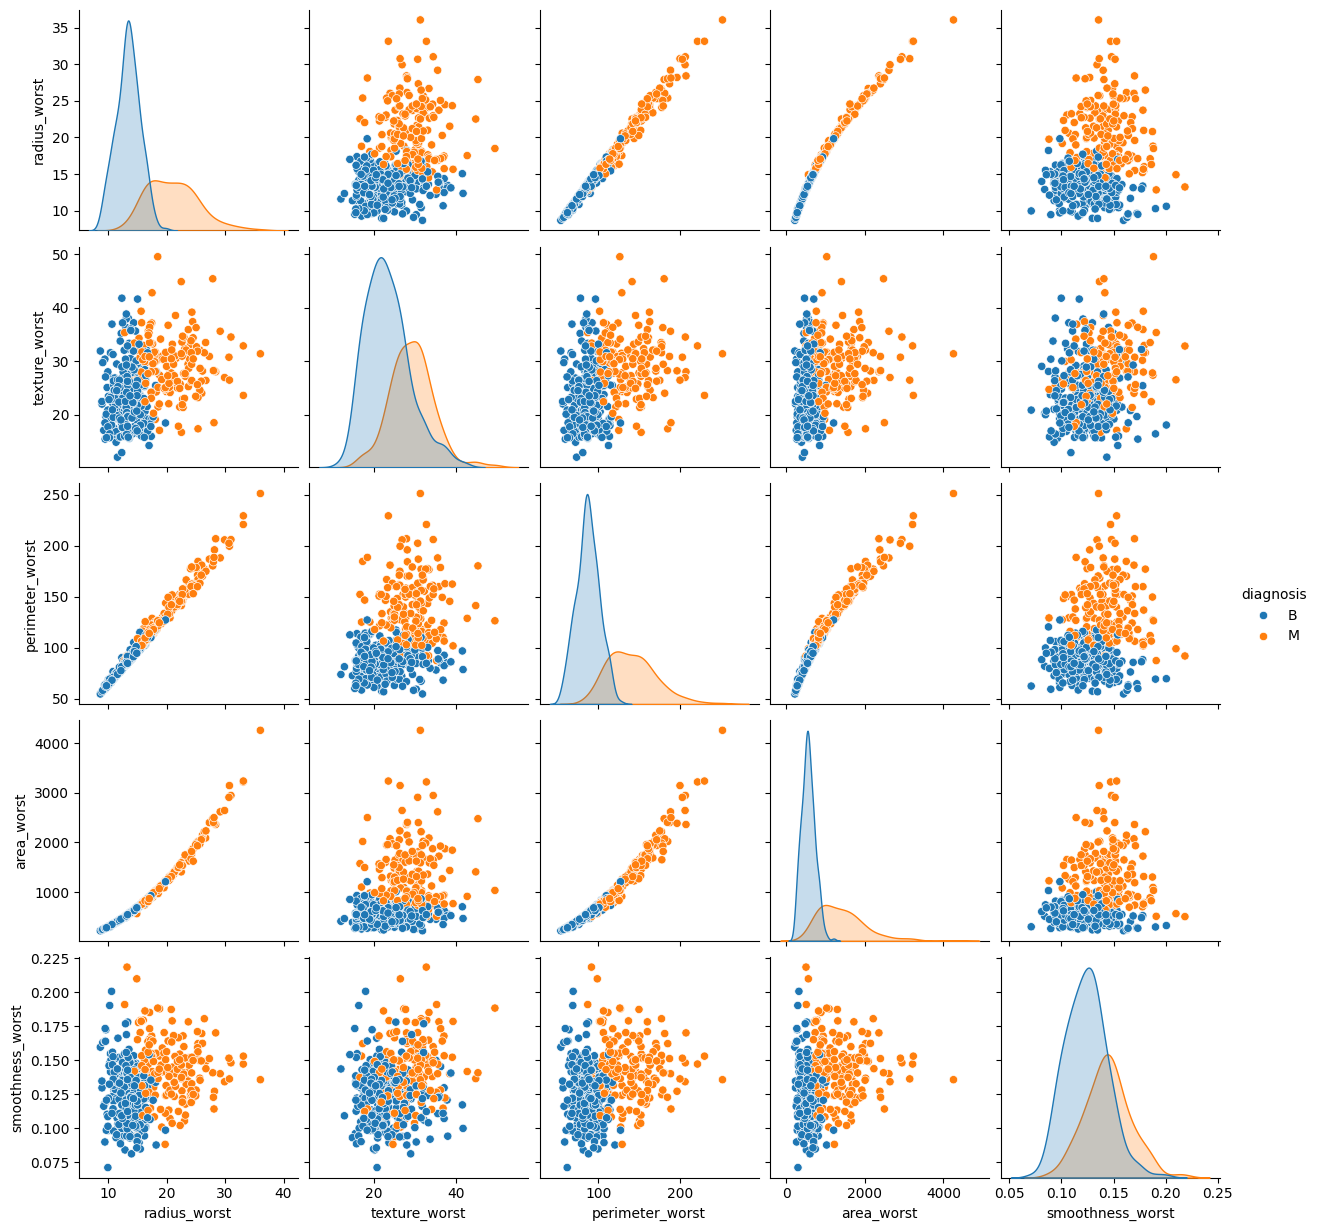

In [18]:
sns.pairplot(train_set[features_num[20:25] + [target]], hue = target)

*Aquí volvemos a encontrar posibles features muy interesantes que correlan entre si y que seguramente correlan con otras anteriores. Seguimos incluyéndolas y apuntándolas por si tuviéramos que prescindir de alguna*

In [19]:
to_investigate_4 = ["radius_worst","perimeter_worst","area_worst"]
corr[to_investigate_1+to_investigate_3 + to_investigate_4].loc[to_investigate_1+to_investigate_3 + to_investigate_4]

,area_mean,perimeter_mean,radius_mean,area_se,perimeter_se,radius_se,radius_worst,perimeter_worst,area_worst
area_mean,1.000000,0.985985,0.986609,0.788217,0.710713,0.722728,0.960519,0.955701,0.959723
perimeter_mean,0.985985,1.000000,0.997850,0.729937,0.676192,0.680739,0.969620,0.969674,0.943283
radius_mean,0.986609,0.997850,1.000000,0.719478,0.656071,0.666954,0.969134,0.963536,0.941849
area_se,0.788217,0.729937,0.719478,1.000000,0.937271,0.951025,0.735075,0.740394,0.793332
perimeter_se,0.710713,0.676192,0.656071,0.937271,1.000000,0.973560,0.676239,0.701606,0.712575
radius_se,0.722728,0.680739,0.666954,0.951025,0.973560,1.000000,0.698484,0.704374,0.737451
radius_worst,0.960519,0.969620,0.969134,0.735075,0.676239,0.698484,1.000000,0.993315,0.983458
perimeter_worst,0.955701,0.969674,0.963536,0.740394,0.701606,0.704374,0.993315,1.000000,0.976979
area_worst,0.959723,0.943283,0.941849,0.793332,0.712575,0.737451,0.983458,0.976979,1.000000


*Sí, hay correlaciones muy altas (entre todas las áreas, perimetros y radios, como era de esperar por otro lado) principalmente entre mean y worst (entre sí y entre las mean por individual contra las worts por individual, por ejemplo perimeter_mean correla al 96% con radius_worst)*

*Todo lo anterior lo tendremos en cuenta en el siguiente ejercicio para hacer nuestra selección de features en diferentes juegos*

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

*Dadas todas las correlaciones, vamos a hacer tres grupos de features: *  
*1. features_num_1, contiene todas menos las que vimos poco interesantes, esas se quedan en features_num_2*  
*2. features_num_2, son las que vimos poco interesantes*  
*3. features_num_0, contiene solo dos features de todas las que eran muy interesantes pero estaban muy correladas entre sí (las que metimos en las listas to_investigate_1, to_investigate_2, to_investigate_3, to_investigate_4). En concreto nos vamos a quedar con area_worst y area_se, porque area continene a perimetro y a radius (geométricamente) y no están tan correladas entre sí. En el futuro veremos una forma matemática de poder asignar un valor informativo respecto a una target categórica (un tipo de coeficiente de correlación) y lo usaremos para seleccionar mejor estas features*  

In [20]:
features_num_1 = [col for col in features_num if col not in features_num_2] # Todas menos las de "2a" categoria
correladas = to_investigate_1 + to_investigate_2 + to_investigate_3 + to_investigate_4
features_num_0 = [col for col in features_num_1 if col not in correladas]
features_num_0 += ["area_worst","area_se"]

*Para este problema vamos a emplear RandomForest, XGBoost, LightGBM y regresión logística (aunque esto nos obligue a un tratamiento adicional :-)*

*Tenemos que tratar las variables numéricas porque Logistic Regression es sensible a las ecalas si no la fueramos a usar podríamos modelar ya*

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

*IMPORTANTE: ESTA PARTE LA HACEMOS PARA USAR LAS FEATURES CON LOGISTIC REGRESSION, SI USAS MODELOS BASADOS EN ARBOLES NO ES ESTRICTAMENTE NECESARIA*

*Antes de poder aplicar un escalado veamos que features necesitan una tranformación para hacer su aspecto más "normal"*

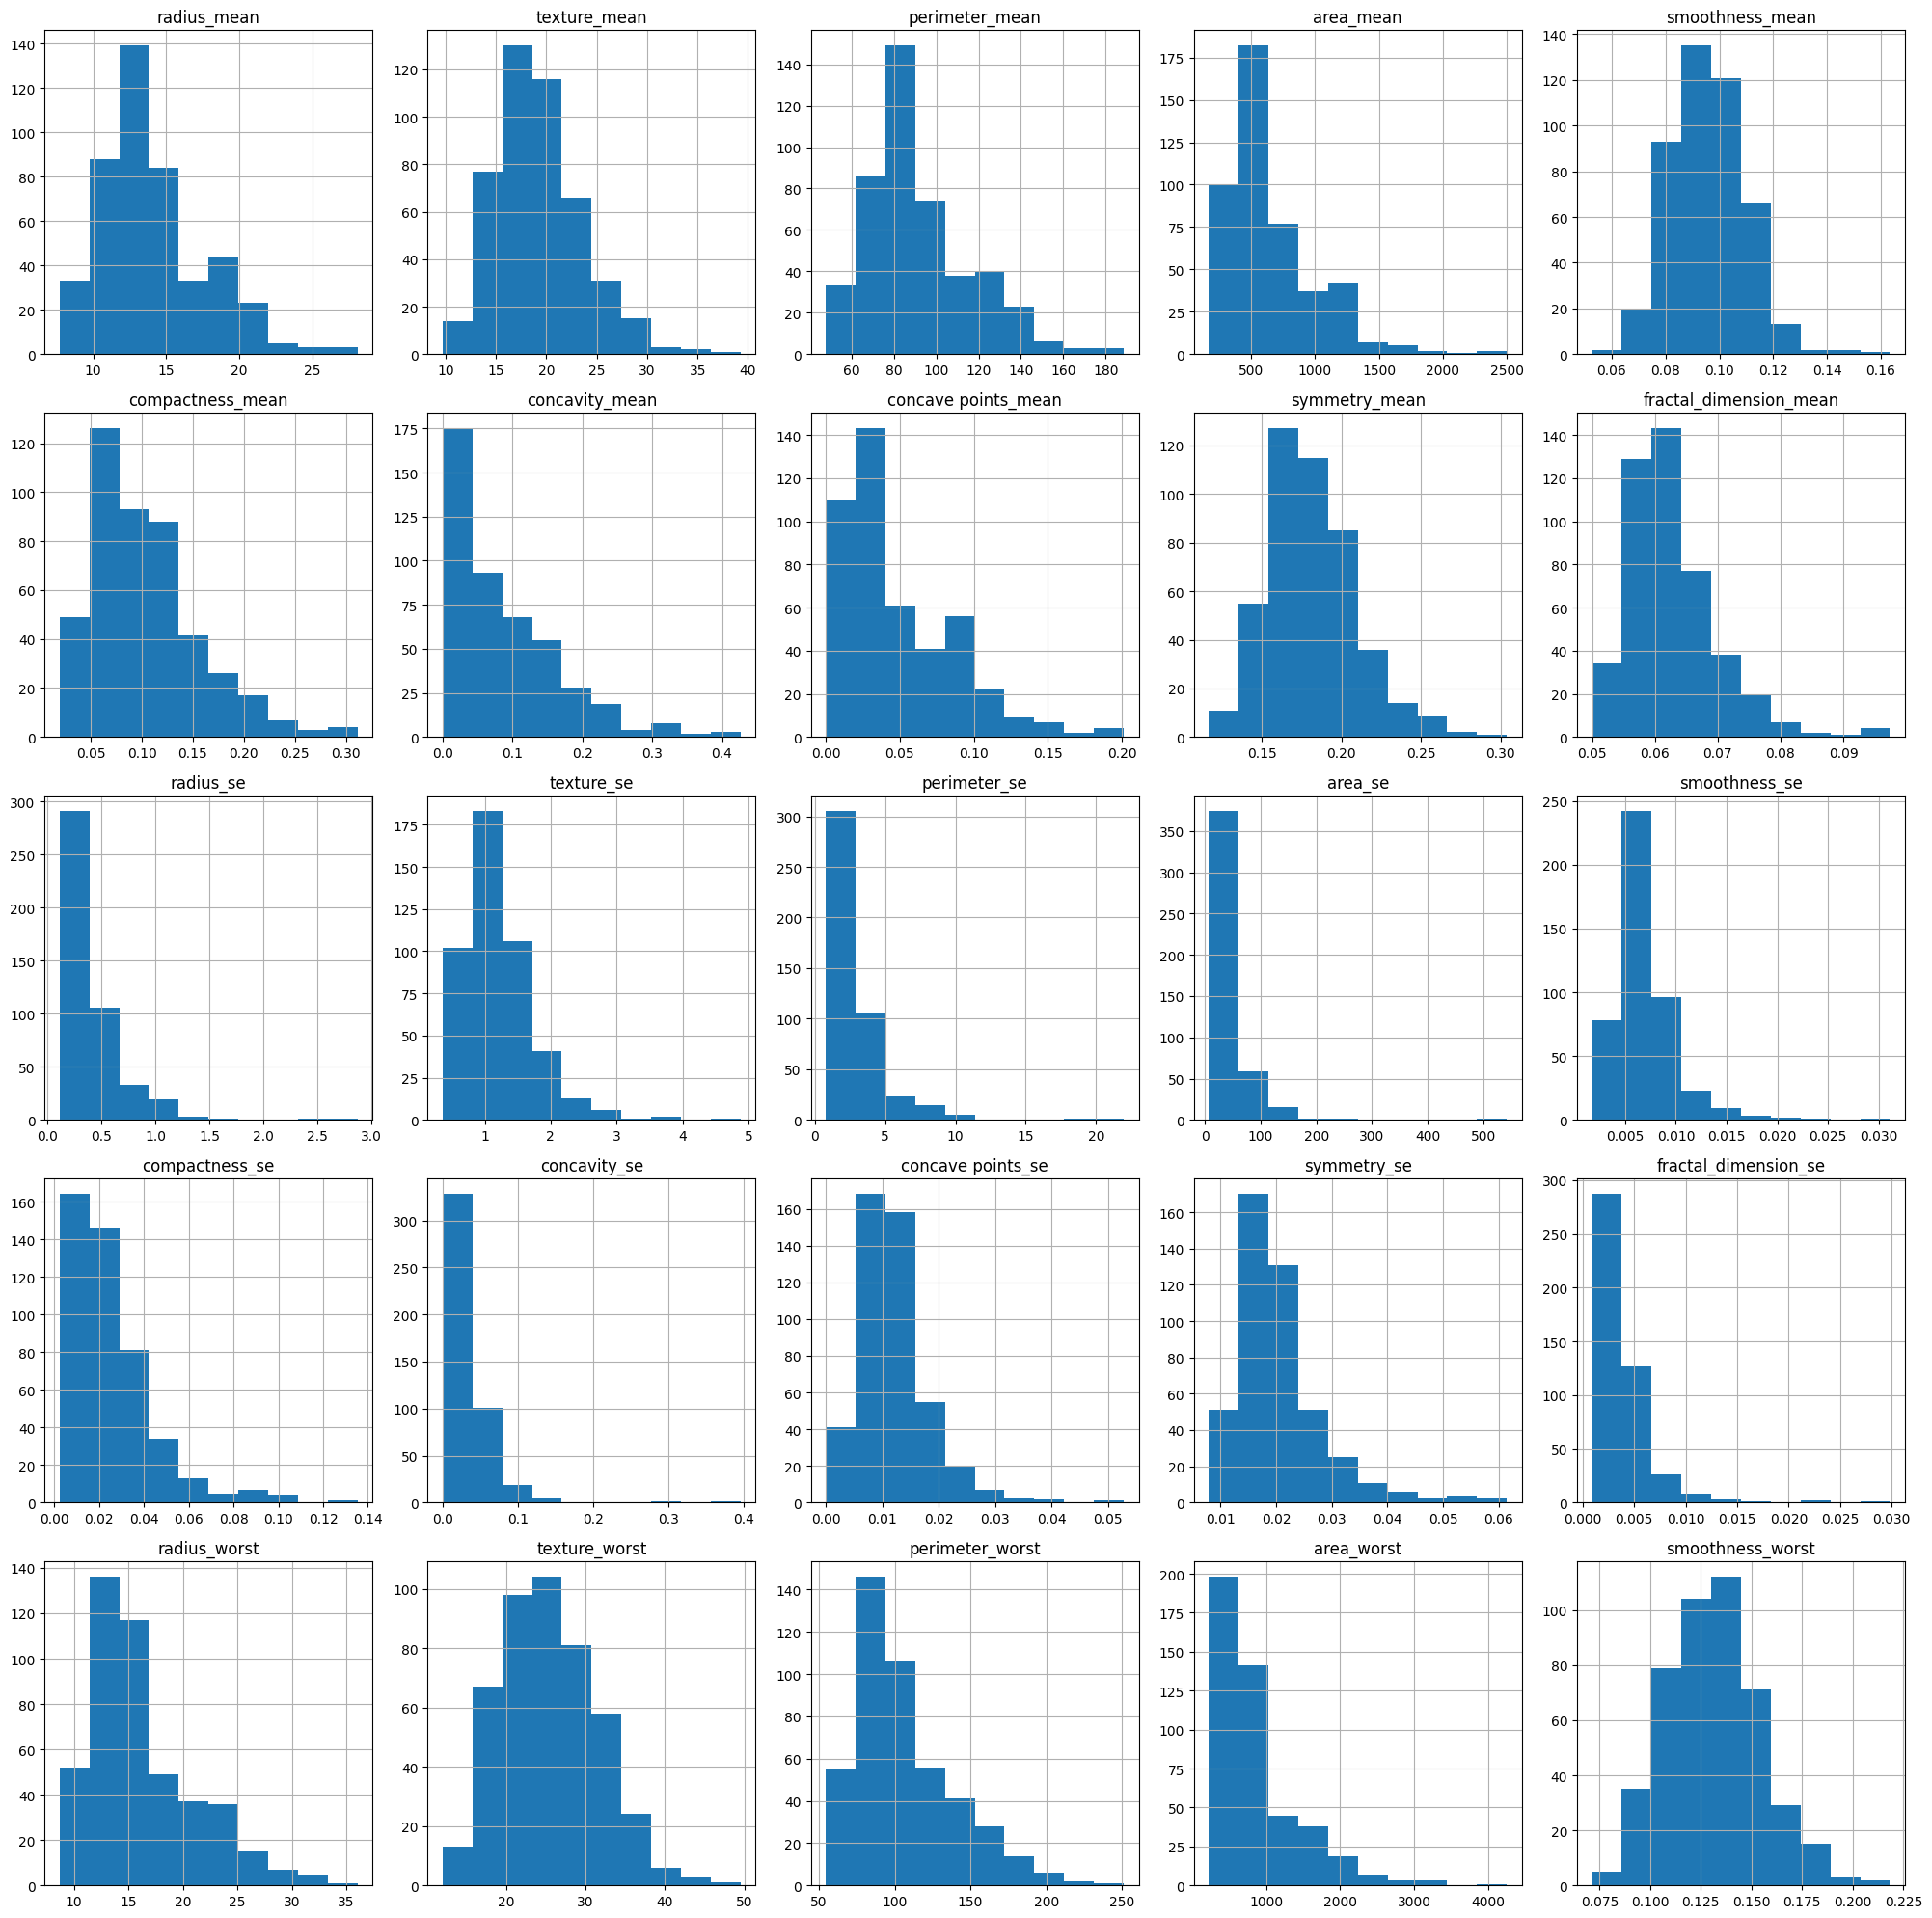

In [21]:

train_set[features_num].hist(figsize = (20,20))
plt.tight_layout()

In [22]:
# Al menos hay que aplicar logaritmo a:
features_to_transform = ['area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'compactness_se',
 'concavity_se',
 'fractal_dimension_se',
 'radius_worst',
 'area_worst']


In [23]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [24]:
for col in features_to_transform:
    desplaza = 0 
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)


In [25]:
scaler = StandardScaler()
train_set_scaled[features_num] = scaler.fit_transform(train_set_scaled[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_scaled[features_num])

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

*Vamos a hacer varios sets para poder probar todos los sets de features, no es necesario que tu hayas hecho lo mismo, puedes hacer un único juego*

In [26]:
y_train = (train_set[target] == "M").astype(int) # Clase 0 -> B, Clase 1 -> M
y_test = (test_set[target] == "M").astype(int) 


X_train_dict = {}
X_test_dict = {}

features_set_name = ["reducido","sin_num_2","todos"]

for set_name,feature_list in zip(features_set_name, [features_num_0,features_num_1,features_num]):
    # Recuerda que features_num ya contiene features_num_2 por eso la usamos al final, para considerar todas las features
    X_train_dict[set_name] = train_set[feature_list]
    X_test_dict[set_name] = test_set[feature_list]

X_train_dict_scaled = {}
X_test_dict_scaled = {}

for set_name,feature_list in zip(features_set_name, [features_num_0,features_num_1,features_num]):
    # Recuerda que features_num ya contiene features_num_2 por eso la usamos al final, para considerar todas las features
    X_train_dict_scaled[set_name] = train_set_scaled[feature_list]
    X_test_dict_scaled[set_name] = test_set_scaled[feature_list]



### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

In [27]:
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth= 6, random_state= 42)
lgb_clf = LGBMClassifier(max_depth= 6, random_sate = 42, verbose = -100)
xgb_clf = XGBClassifier(max_depth = 6, random_state = 42)

modelos = {
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "Lightgbm": lgb_clf,
    "XGBoost": xgb_clf
}

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

In [28]:
# Para scoring precision
scoring_func = make_scorer(precision_score, pos_label = 1)
for feature_set, X_train in X_train_dict.items():
    X_train_scaled = X_train_dict_scaled[feature_set]
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos.items():
        print(f"{tipo}: ", end = " ")
        if tipo != "Regresion Logistica":
            print(np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = scoring_func)))
        else:
            print(np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = scoring_func)))
    print("******")


Para el set reducido:
Regresion Logistica:  0.9694842159737795
Random Forest:  0.9702002164502165
Lightgbm:  0.9591392118787756
XGBoost:  0.9470707960603597
******
Para el set sin_num_2:
Regresion Logistica:  0.9761029411764707
Random Forest:  0.9523952762923351
Lightgbm:  0.943723245145659
XGBoost:  0.9696513282732449
******
Para el set todos:
Regresion Logistica:  0.9766284695696459
Random Forest:  0.9459436633891093
Lightgbm:  0.9638798701298701
XGBoost:  0.9755336812144213
******


*Así de primeras, dada la escasa diferencia nos quedariamos con la regresión logística*

In [29]:
# Para scoring balanced_accuracy

for feature_set, X_train in X_train_dict.items():
    X_train_scaled = X_train_dict_scaled[feature_set]
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos.items():
        print(f"{tipo}: ", end = " ")
        if tipo != "Regresion Logistica":
            print(np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")))
        else:
            print(np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy")))
    print("******")


Para el set reducido:
Regresion Logistica:  0.9558750740025428
Random Forest:  0.9617574269437192
Lightgbm:  0.9612789580441976
XGBoost:  0.9548592576776626
******
Para el set sin_num_2:
Regresion Logistica:  0.9606008844719212
Random Forest:  0.9565833956086973
Lightgbm:  0.9501636952421622
XGBoost:  0.9647877299740223
******
Para el set todos:
Regresion Logistica:  0.9695135404434007
Random Forest:  0.9429465467097579
Lightgbm:  0.9601224155723995
XGBoost:  0.9665421159389345
******


*Mantenemos nuestra eleccion: Regresión Logistica*

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [30]:
# Para la precision de "M" (clase 1)
param_grid = {
    "C": [0.1, 1,10,100], # 
    "class_weight": ["balanced",None],
    "max_iter": [1000,5000,10000]
}

lr_grid = GridSearchCV(lr_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = scoring_func)

lr_grid.fit(X_train_dict_scaled[features_set_name[-1]], y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'max_iter': [1000, 5000, 10000]},
             scoring=make_scorer(precision_score, response_method='predict', pos_label=1))

In [31]:
print(lr_grid.best_params_)

{'C': 0.1, 'class_weight': None, 'max_iter': 1000}


In [32]:
print(lr_grid.best_score_)

0.9819964349376115


In [33]:
# Para "balanced_accuracy"
param_grid = {
    "C": [0.1, 1,10,100], # 
    "class_weight": ["balanced",None],
    "max_iter": [1000,5000,10000]
}

lr2_grid = GridSearchCV(lr_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "balanced_accuracy")

lr2_grid.fit(X_train_dict_scaled[features_set_name[-1]], y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'max_iter': [1000, 5000, 10000]},
             scoring='balanced_accuracy')

In [34]:
print(lr2_grid.best_params_)

{'C': 1, 'class_weight': None, 'max_iter': 1000}


In [35]:
print(lr2_grid.best_score_)

0.9695135404434007


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [36]:
y_pred = lr_grid.best_estimator_.predict(X_test_dict_scaled[features_set_name[-1]])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



*Nos ha salido un modelo extraordinarimante bueno, no es lo normal. Pero a veces puede pasar, en este caso se sabe que el reconocimienot de imagenes de mamografías (del que derivan estos datos) es uno de los campos de aplicación con más acierto del ML*

In [37]:
y_pred_2 = lr2_grid.best_estimator_.predict(X_test_dict_scaled[features_set_name[-1]])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



*Es bueno en cualquira de las métricas*

### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

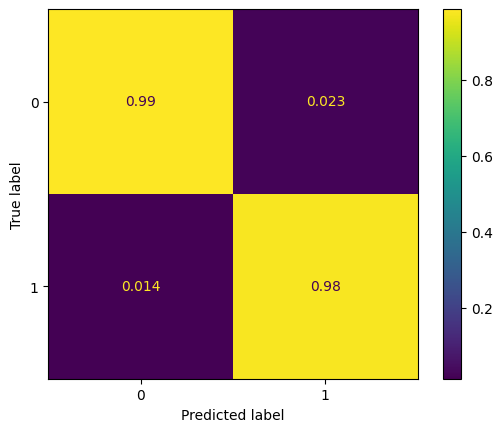

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize= "pred")

*Poco hay que decir en este caso, tenemos un modelo casi perfecto, y en general eso debería ponerlo bajo sospecha, antes de ir a la parte de análisis de errores, pero no está mal coger hábito y mirar las matrices de confusión siempre.*

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.

#### Con pickle

*Pickle es un módulo que permite grabar cualquier tipo de objeto en formato binario en un archivo y luego recuperarlo con el mismo formato*

In [39]:
import pickle

# Creamos el directorio si no existe
os.makedirs("models", exist_ok= True)


# Guardar el modelo en un archivo
with open('cancer_pred.pkl', 'wb') as file:
    pickle.dump(lr_grid.best_estimator_, file)


In [40]:
# Para cargarlo


# Cargar el modelo
with open('cancer_pred.pkl', 'rb') as file:
    model = pickle.load(file)

# Ahora 'model' está listo para usarse como antes
y_pred = model.predict(X_train_dict_scaled[features_set_name[-1]])